In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/unix/sjohri/.local/lib/python3.8/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==0.25.3 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


## Read data files

In [3]:
# Vision signatures
path = "/home/unix/sjohri/valab_sjohri/projects/methods/testing_parameters/melanoma-tirosh/"
vision_sig = pd.read_csv(path+"vision_hallmark_sig.csv",index_col=0)
vision_sig = vision_sig.drop(["HALLMARK_KRAS_SIGNALING","HALLMARK_UV_RESPONSE"], axis=1)
# Signatures file
sig_df = pd.read_csv("/home/unix/sjohri/valab_sjohri/projects/methods/hallmark.csv")
# Read counts 
adata = sc.read(path+"melanoma-tirosh-processed.h5")
counts_df = pd.DataFrame(adata.raw.X, columns=adata.raw.var_names, index = adata.raw.obs_names)

In [4]:
print(vision_sig.shape,sig_df.shape,counts_df.shape)

(7186, 46) (200, 50) (7186, 22454)


In [5]:
signature_names_list = vision_sig.columns

In [6]:
t1_ids = list(set(adata.obs[adata.obs["treatment.group"]=="treatment.naive"].samples))
t2_ids = list(set(adata.obs[adata.obs["treatment.group"]=="post.treatment"].samples))

In [7]:
d1_all = {}
for xid in t1_ids:
    d1_all[xid]=adata.obs[adata.obs.samples==xid]["samples"].index.to_list()
d2_all = {}
for xid in t2_ids:
    d2_all[xid]=adata.obs[adata.obs.samples==xid]["samples"].index.to_list()

## Test package

In [8]:
import driver_genes as dg

In [9]:
top_genes = dict()
for x in tqdm(signature_names_list):
    top_genes[x] = dg.FindDriverGenes(x,vision_sig,counts_df,sig_df[x].dropna().values, "spearman")

## Make Heatmap

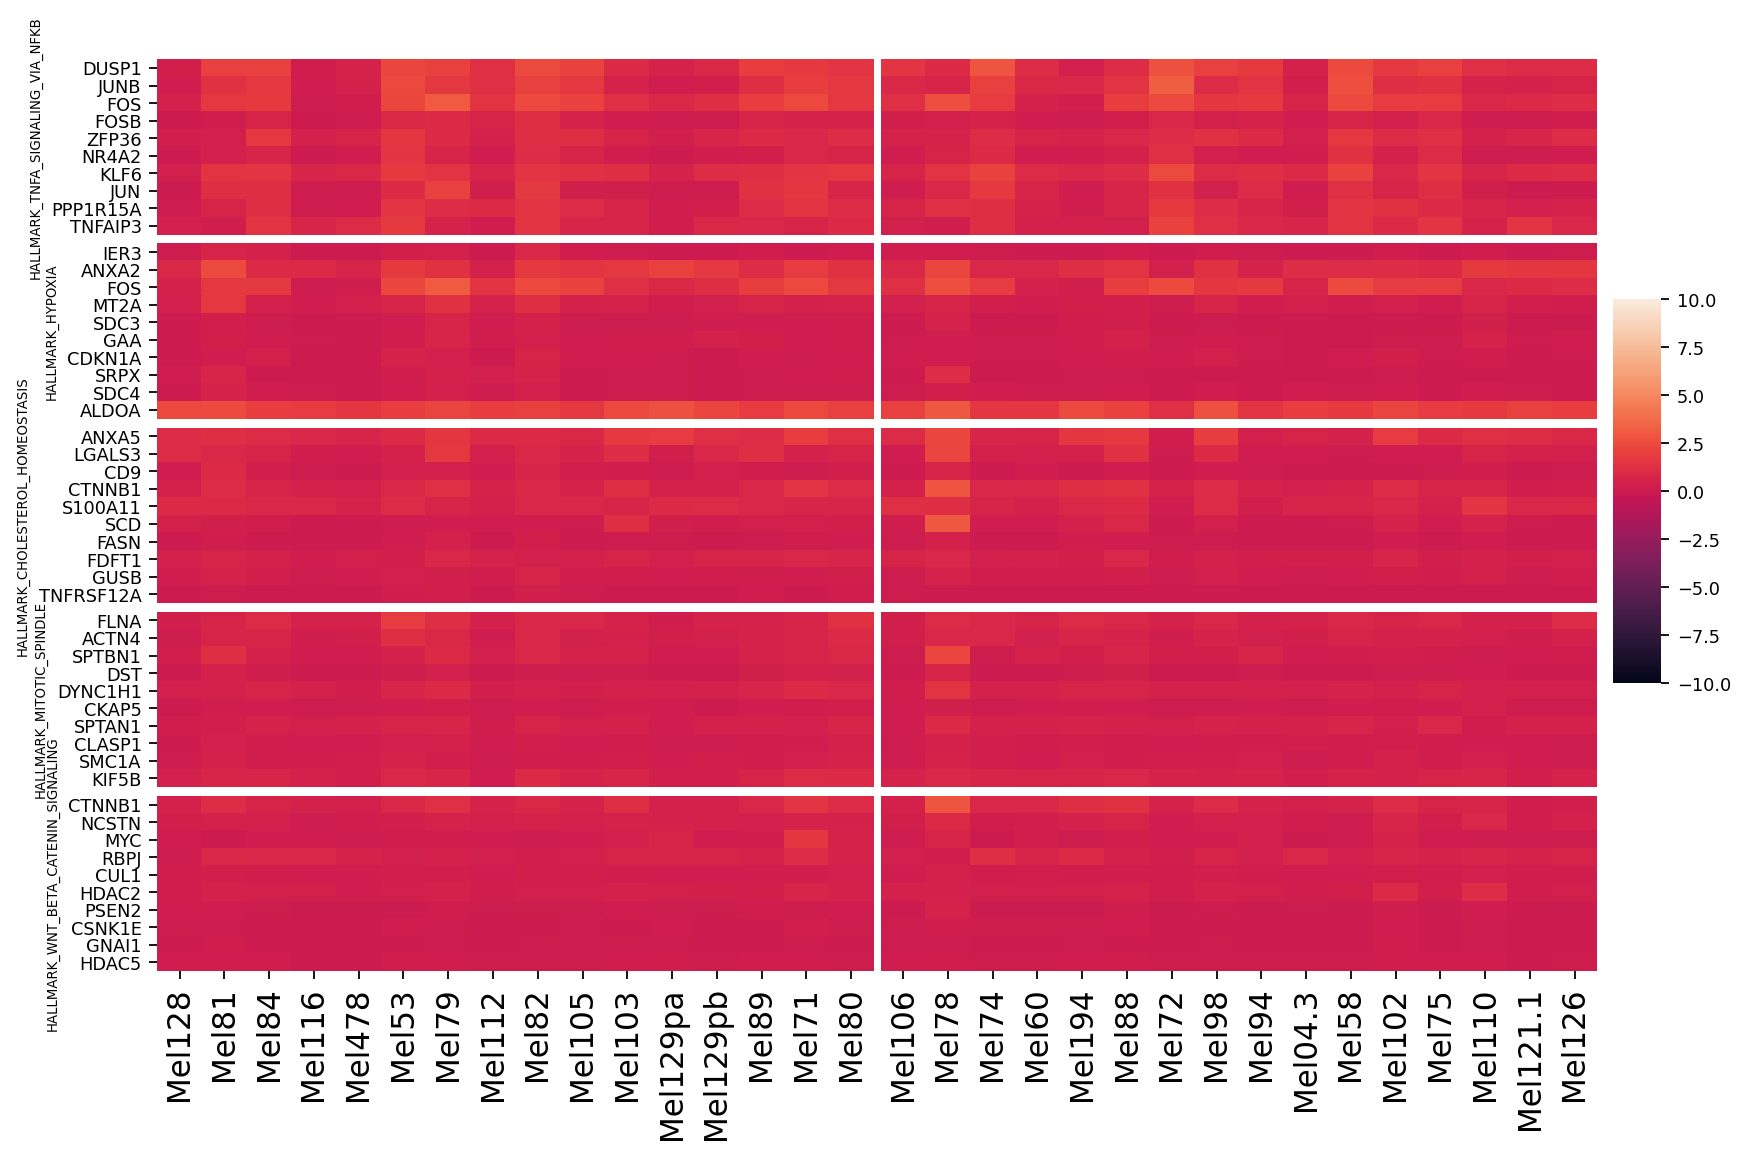

In [10]:
fig1 = dg.GenerateHeatmap(counts_df, t1_ids, t2_ids, d1_all, d2_all, top_genes, signature_names_list[:5])

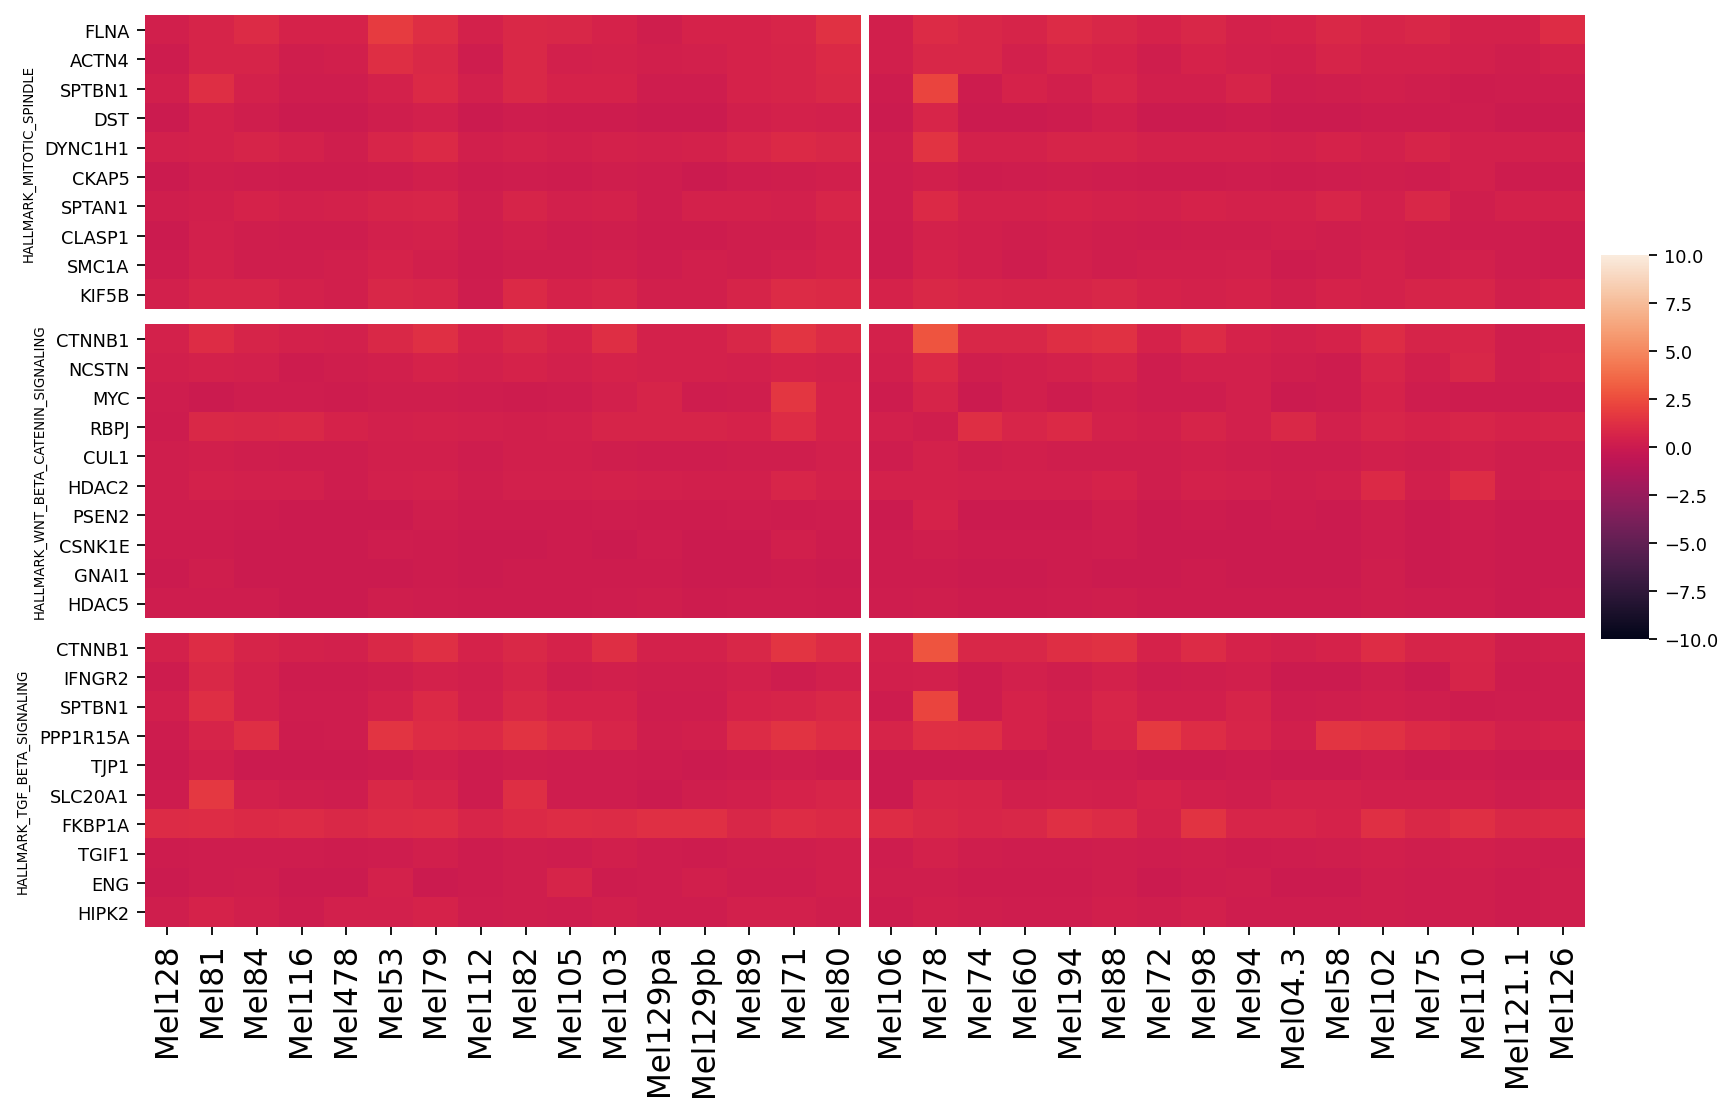

In [11]:
fig2 = dg.GenerateHeatmap(counts_df, t1_ids, t2_ids, d1_all, d2_all, top_genes, signature_names_list[3:6])

## Make UpsetPlot

In [ ]:
import upsetplot
from itertools import product

In [ ]:
upset_df_prep = pd.DataFrame(columns=top_genes.keys())
for x in top_genes.keys():
    upset_df_prep[x] = top_genes[x].index

In [ ]:
upset_df_prep

In [ ]:
top_features = upset_df_prep.columns[:6]

upset_df = pd.DataFrame(list(product([True,False],repeat = len(top_features))),columns=top_features)
intersection = list()
for i in range(upset_df.shape[0]):
    sig_names = upset_df.columns[upset_df.iloc[i,]]
    temp = upset_df_prep[sig_names]
    list_sigs = [set(temp.iloc[:,i].dropna()) for i in range(temp.shape[1])]
    if len(list_sigs)!=0:
        intersection.append(len(set.intersection(*list_sigs)))
    else:
        intersection.append(0)
upset_df["Intersection"] = intersection
upset_df = upset_df.groupby(by = top_features.to_list()).first()
upset_df

In [ ]:
upsetplot.plot(upset_df['Intersection'], sort_by='cardinality')